# Benchmark for Community detection

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering_with_hop_distance, extract_labels_from_communities, time_tester, calculate_scores_CD

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_node_labels

from PlotHelperFunctions import plot_and_save_community,normalize_score_column_community

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity


import data.jazz as jazz
import data.cora as cora

## Create Graphs

In [2]:


cora_graph = cora.get_graph()

cora_graph = nx.relabel_nodes(cora_graph, {list(cora_graph.nodes())[i] : i for i in range(len(cora_graph.nodes()))} )
cora_truth = list(cora_graph.nodes[i]['subject'] for i in range(len(cora_graph.nodes())))



jazz_graph = jazz.get_graph()
jazz_graph = nx.relabel_nodes(jazz_graph, {i : i-1 for i in range(len(jazz_graph)+1)} )
jazz_graph,_ = randomize_graph_node_labels(jazz_graph,None)
jazz_truth = None


karate_graph = nx.karate_club_graph()
karate_truth = list(karate_graph.nodes[i]["club"] for i in range(34))


erdos_renyi_graph,erdos_renyi_truth = generate_graph(10,25,0.2,0.05)



## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [3]:
import itertools
import timeit 
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2),(0.25,0.35), (0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(1):
        f = treshold[0]   #f-bound
        e = treshold[1]   
    
        
        graphs = [karate_graph,cora_graph,jazz_graph,erdos_renyi_graph]
        expected_clusters = [2,7,None,25]
        graph_names = [ 'Karate Club','Cora','Jazz','25 random communities']
        graph_truths =  [karate_truth,cora_truth,jazz_truth,erdos_renyi_truth]
        
        
        𝓗 = Modularity(1.0)
        
        fn_louvain_mod = lambda G,_: louvain(G, 𝓗)
        fn_leiden_mod  = lambda G,_: leiden(G, 𝓗)
        
        louv_out = None
        lei_out = None
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)']
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='B',pre = pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='F',pre = pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_hop_distance(agents, f, e, initial_clustering,mode='E',pre = pre)
        
        algorithms = [ fn_louvain_mod, fn_leiden_mod,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'Louvain (Mod)', 'Leiden (Mod)','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
        
        
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(graphs, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
            
            graph, truth = randomize_graph_node_labels(graph,truth)
            graph = [graph]
            truth = [truth]
              
            agents = []
            for i in range(len(graph)):
                agents += [list(graph[i].nodes())]
        
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                initial_clusters = len(agents[0])
                if g_name == 'Cora':
                    a_name_modified += ' *6 starting clusters'
                    initial_clusters = 6
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # starting with predicted number of clusters
                a_name_modified = a_name + ' starting with predicted number of clusters'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,None)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                
                # start with the output of leiden
                a_name_modified = a_name + ' starting with the output of leiden'
                initial_clusters = clusters
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                
                test_callable = lambda a: algo(a,initial_clusters,fn_leiden_mod)
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
        
                rand_score_with_init = sum(rand_score(list(out.values()), list(lei.values())) for out, lei in zip(outputs, lei_output)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
               
        
            else:
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a,_)
                times,outputs = time_tester(test_callable,graph)
                outputs = [extract_labels_from_communities(c.communities) for c in outputs]
        
                if algo == fn_leiden_mod:
                    lei_output = outputs
                    
                
                avg_time = sum(times)/len(times)
                scores = calculate_scores_CD(outputs,truth,graph)
                scores['Time'] = avg_time
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
    records = []
    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        # metrics_list is a list of 10 dictionaries
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)


Running Louvain (Mod) on Karate Club … execution time: ~ 0.005941 seconds.
Rand Index : ~ 0.5080213903743316
Modularity : ~ 0.440181031090122
Time : ~ 0.005941000068560243
Running Leiden (Mod) on Karate Club … execution time: ~ 0.012783 seconds.
Rand Index : ~ 0.5187165775401069
Modularity : ~ 0.4400873296977193
Time : ~ 0.012782700010575354
Running LP (Balanced) Heuristic starting with everyone alone on Karate Club … execution time: ~ 0.007466 seconds.
Rand Index : ~ 0.5080213903743316
Modularity : ~ 0.25200989486703773
Time : ~ 0.007466099923476577
Running LP (Balanced) Heuristic starting with predicted number of clusters on Karate Club … execution time: ~ 0.001938 seconds.
Rand Index : ~ 0.48663101604278075
Modularity : ~ 0.3998332115215232
Time : ~ 0.0019375999690964818
Running LP (Balanced) Heuristic starting with the output of leiden on Karate Club … execution time: ~ 0.012945 seconds.
Rand Index : ~ 0.5115864527629234
Modularity : ~ 0.4295552931916568
Rand Score with initial clu

In [4]:
avg_stds = {}

for df in dfs:
    for col in ['Rand Index']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        current_avg = stds.mean()
        if col in avg_stds:
            avg_stds[col].append(current_avg)
        else:
            avg_stds[col] = [current_avg]

# If you want the overall average across all DataFrames:
overall_avg_stds = {col: np.nanmean(values) for col, values in avg_stds.items()}

print(overall_avg_stds)

{'Rand Index': np.float64(0.0)}


Figure saved as ./figures/PopularCommunity/Karate Club-Rand Index.png


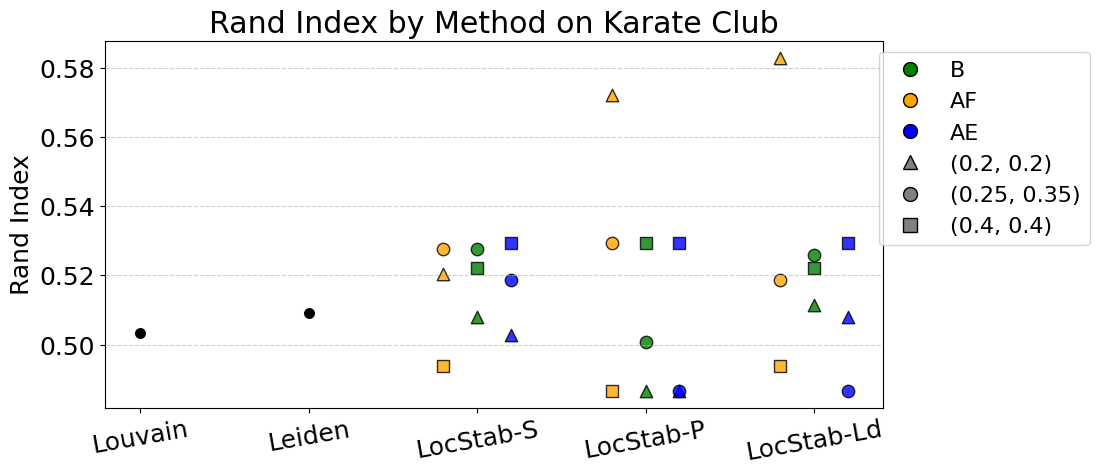

Figure saved as ./figures/PopularCommunity/Karate Club-Modularity.png


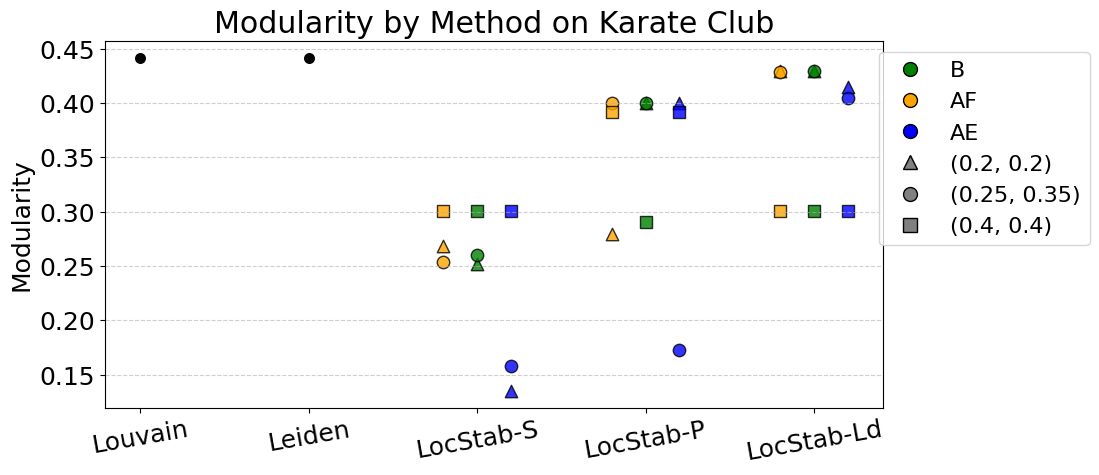

Figure saved as ./figures/PopularCommunity/Jazz-Rand Index.png


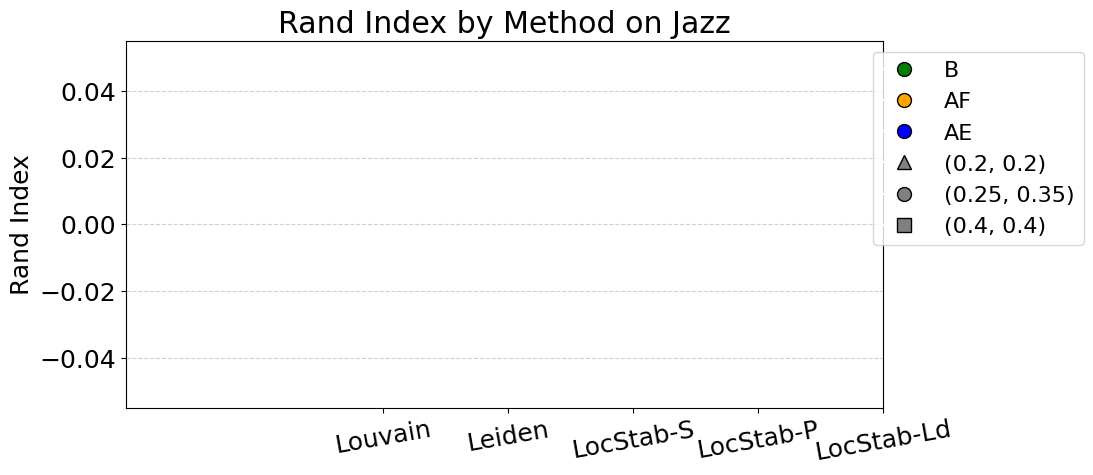

Figure saved as ./figures/PopularCommunity/Jazz-Modularity.png


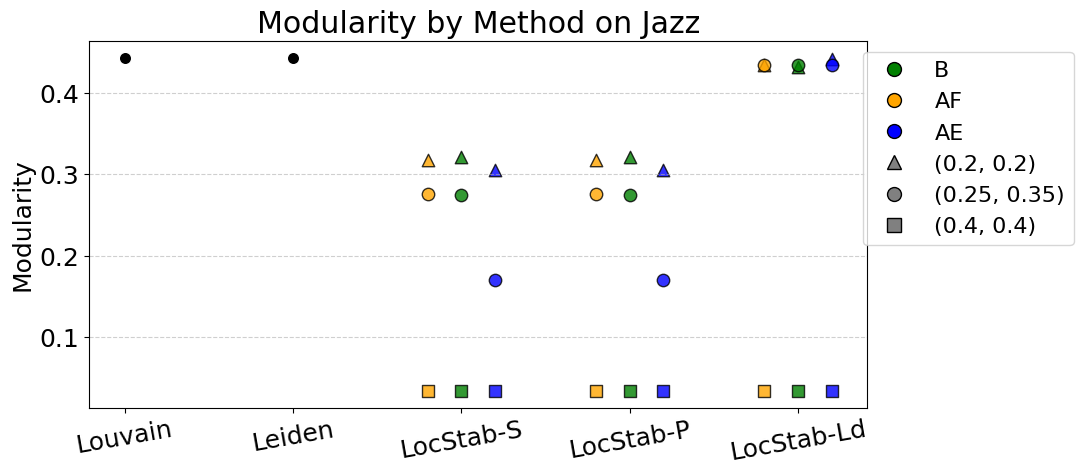

Figure saved as ./figures/PopularCommunity/Cora-Rand Index.png


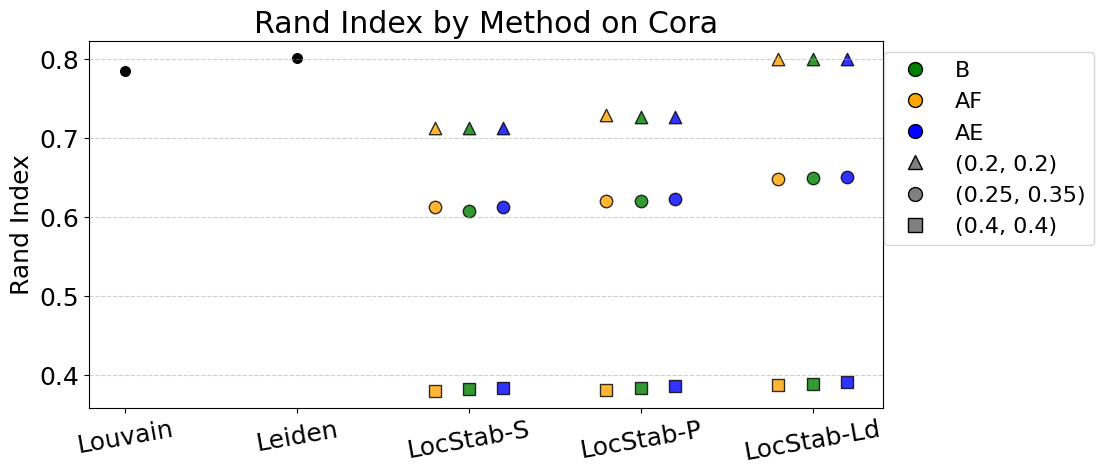

Figure saved as ./figures/PopularCommunity/Cora-Modularity.png


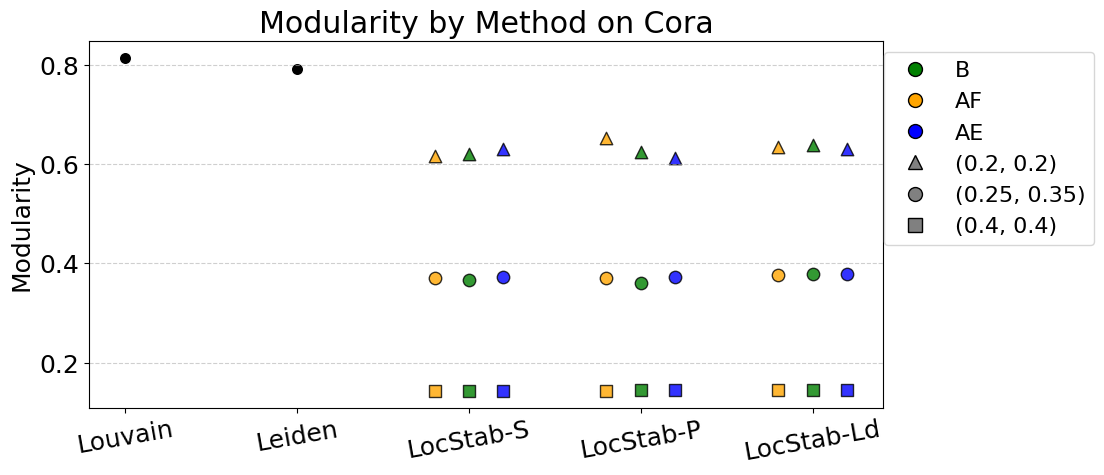

Figure saved as ./figures/PopularCommunity/Random-25-Rand Index.png


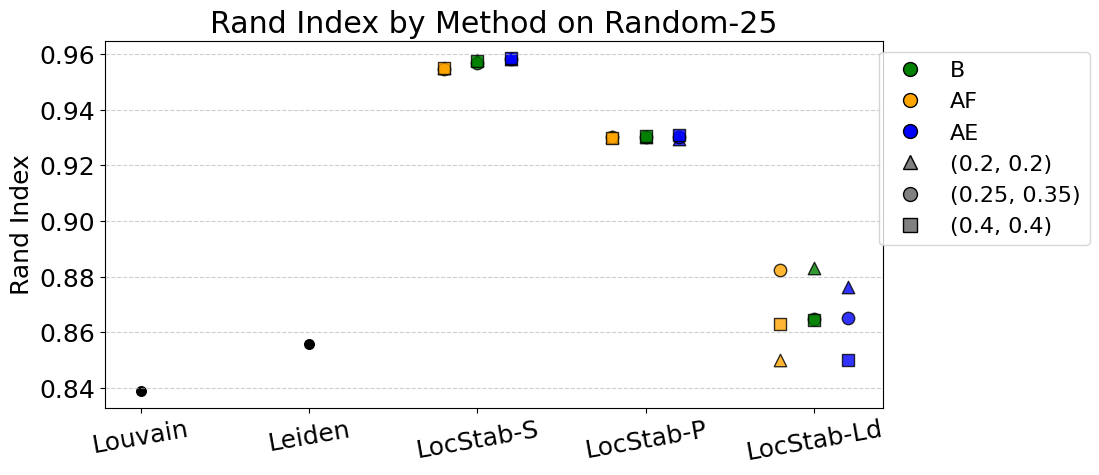

Figure saved as ./figures/PopularCommunity/Random-25-Modularity.png


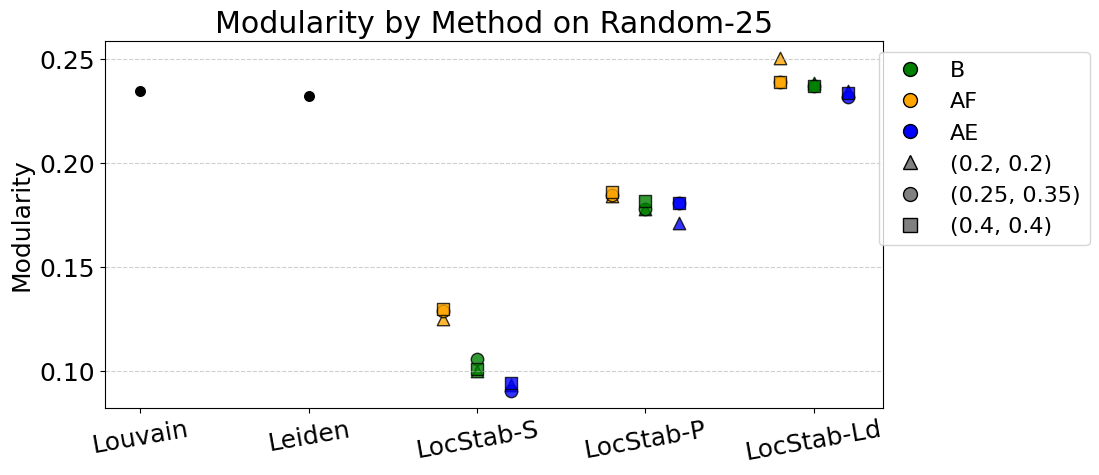

In [5]:
for df in dfs:
    df.replace("n.A.", np.nan, inplace=True)
    df.replace("25 random communities", "Random-25",inplace=True)

score_cols = ['Rand Index', 'Modularity']
dfs = [normalize_score_column(df, score_cols) for df in dfs]
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]
# Then call your plotting
for Dataset in ['Karate Club', 'Jazz', 'Cora', 'Random-25']:
    for score in score_cols:
        plot_and_save_community(
            dfs, labels, Dataset, score,
            save_path=f'./figures/PopularCommunity/{Dataset}-{score}.png'
        )